In [ ]:
!pip install -U git+https://github.com/albu/albumentations --no-cache-dir

  Cloning https://github.com/albu/albumentations to /tmp/pip-req-build-5t3_4d9z
  Running command git clone -q https://github.com/albu/albumentations /tmp/pip-req-build-5t3_4d9z
     |████████████████████████████████| 47.8 MB 7.5 MB/s 
  Created wheel for albumentations: filename=albumentations-1.1.0-py3-none-any.whl size=112723 sha256=edc86c7d17a2aebcdb77f6dabb91f3beaa6ab5ec6d4368ef899bf1a90d6663bf
  Stored in directory: /tmp/pip-ephem-wheel-cache-jv0dhghw/wheels/63/11/1a/c77caf3ae9b9b6d57b3ee5e6a41a50f3bc12c66a70f6b90bf0
Successfully built albumentations
  Attempting uninstall: albumentations
    Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12


In [ ]:
pip install segmentation_models_pytorch

     |████████████████████████████████| 88 kB 3.2 MB/s 
     |████████████████████████████████| 376 kB 11.0 MB/s 
     |████████████████████████████████| 58 kB 6.8 MB/s 
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.6.3-py3-none-any.whl size=12421 sha256=1f40f21b74fe69b559eee6c01aee5a2573e99bd94ee075645391293fe350db0f
  Stored in directory: /root/.cache/pip/wheels/90/6b/0c/f0ad36d00310e65390b0d4c9218ae6250ac579c92540c9097a
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60965 sha256=0f21dc7491b7379fd435572c7bf100bbf1314de87135e467991a9e58351db672
  Stored in directory: /root/.cache/pip/wheels/ed/27/e8/9543d42de2740d3544db96aefef63bda3f2c1761b3334f4873
Successfully built efficientnet-pytorch pretrainedmodels


In [ ]:
pip uninstall opencv-python-headless

Found existing installation: opencv-python-headless 4.5.5.64
Uninstalling opencv-python-headless-4.5.5.64:
  Would remove:
    /usr/local/lib/python3.7/dist-packages/cv2/*
    /usr/local/lib/python3.7/dist-packages/opencv_python_headless-4.5.5.64.dist-info/*
    /usr/local/lib/python3.7/dist-packages/opencv_python_headless.libs/libavcodec-65fa80df.so.58.134.100
    /usr/local/lib/python3.7/dist-packages/opencv_python_headless.libs/libavformat-8ef5c7db.so.58.76.100
    /usr/local/lib/python3.7/dist-packages/opencv_python_headless.libs/libavutil-9c768859.so.56.70.100
    /usr/local/lib/python3.7/dist-packages/opencv_python_headless.libs/libbz2-a273e504.so.1.0.6
    /usr/local/lib/python3.7/dist-packages/opencv_python_headless.libs/libcrypto-09fe7800.so.1.1
    /usr/local/lib/python3.7/dist-packages/opencv_python_headless.libs/libgfortran-91cc3cb1.so.3.0.0
    /usr/local/lib/python3.7/dist-packages/opencv_python_headless.libs/libopenblas-r0-f650aae0.3.3.so
    /usr/local/lib/python3.7/dis

In [ ]:
pip install opencv-python-headless==4.1.2.30

     |████████████████████████████████| 21.8 MB 1.5 MB/s 


In [ ]:
!pip install wandb -qqq
import wandb

     |████████████████████████████████| 1.8 MB 4.2 MB/s 
     |████████████████████████████████| 144 kB 44.8 MB/s 
     |████████████████████████████████| 181 kB 40.1 MB/s 
     |████████████████████████████████| 63 kB 962 kB/s 


In [ ]:
import os
import torch 
import numpy as np
from torch import nn
import matplotlib.pyplot as plt
from google.colab import drive
import pandas as pd
import albumentations as A
from torch.utils.data import DataLoader, Dataset, sampler
import cv2
from albumentations import (HorizontalFlip, VerticalFlip, ShiftScaleRotate, Normalize, Resize, Compose, GaussNoise)
from sklearn.metrics import jaccard_score
import segmentation_models_pytorch as seg
from torch import optim
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm
from sklearn.metrics import accuracy_score, f1_score
import albumentations.augmentations.crops.transforms as transform

In [ ]:
wandb.login()

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [ ]:
%matplotlib inline 

In [ ]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
class config:
  DIRECTORY_PATH = "/content/gdrive/MyDrive/Kaggle_challenge/data/"
  TRAIN_CSV = DIRECTORY_PATH + "/train.csv"
  TRAIN_PATH = DIRECTORY_PATH + "/train"
  TEST_PATH = DIRECTORY_PATH + "/test"
  TRAIN_SEMI_SUPERVISED_PATH = DIRECTORY_PATH + "/train_semi_supervised"
  
  SEED = 42
  
  RESNET_MEAN = (0.485, 0.456, 0.406)
  RESNET_STD = (0.229, 0.224, 0.225)
  
  IMAGE_RESIZE = (256, 256)

  LEARNING_RATE = 5e-4
  EPOCHS = 35

  INIT_LR = 0.001

  THRESHOLD = 0.5

  BATCH_SIZE = 64

  DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
  PIN_MEMORY = True if DEVICE == 'cuda' else False

  BASE_OUTPUT = '/content/gdrive/MyDrive/Kaggle_challenge/output'


  MODEL_PATH = os.path.join(BASE_OUTPUT ,'/', 'unet_sartorius')
  PLOT_PATH   = os.path.sep.join([BASE_OUTPUT ,'/plot.png'])
  TEST_PATHS = os.path.sep.join([BASE_OUTPUT, 'test_paths.txt'])

  MIN_SCORE = 0.59



In [ ]:
torch.__version__

'1.10.0+cu111'

In [ ]:
config.DEVICE

'cuda'

In [ ]:
config.PIN_MEMORY

True

In [ ]:
df_train = pd.read_csv(config.TRAIN_CSV)
df_train.head(10)

id                                         annotation  width  \
0  0030fd0e6378  118145 6 118849 7 119553 8 120257 8 120961 9 1...    704   
1  0030fd0e6378  189036 1 189739 3 190441 6 191144 7 191848 8 1...    704   
2  0030fd0e6378  173567 3 174270 5 174974 5 175678 6 176382 7 1...    704   
3  0030fd0e6378  196723 4 197427 6 198130 7 198834 8 199538 8 2...    704   
4  0030fd0e6378  167818 3 168522 5 169225 7 169928 8 170632 9 1...    704   
5  0030fd0e6378  205984 2 206687 4 207391 5 208095 5 208799 6 2...    704   
6  0030fd0e6378  203101 2 203805 5 204509 7 205213 10 205917 12...    704   
7  0030fd0e6378  191900 2 192604 3 193308 4 194012 5 194717 5 1...    704   
8  0030fd0e6378  184848 3 185551 5 186254 7 186958 8 187662 9 1...    704   
9  0030fd0e6378  165119 1 165822 4 166526 6 167230 9 167935 9 1...    704   

   height cell_type plate_time sample_date  \
0     520    shsy5y  11h30m00s  2019-06-16   
1     520    shsy5y  11h30m00s  2019-06-16   
2     520    shsy5y  11h30m00s  2019-06-16   
3     520    shsy5y  11h30m00s  2019-06-16   
4     520    shsy5y  11h30m00s  2019-06-16   
5     520    shsy5y  11h30m00s  2019-06-16   
6     520    shsy5y  11h30m00s  2019-06-16   
7     520    shsy5y  11h30m00s  2019-06-16   
8     520    shsy5y  11h30m00s  2019-06-16   
9     520    shsy5y  11h30m00s  2019-06-16   

                            sample_id elapsed_timedelta  
0  shsy5y[diff]_E10-4_Vessel-714_Ph_3   0 days 11:30:00  
1  shsy5y[diff]_E10-4_Vessel-714_Ph_3   0 days 11:30:00  
2  shsy5y[diff]_E10-4_Vessel-714_Ph_3   0 days 11:30:00  
3  shsy5y[diff]_E10-4_Vessel-714_Ph_3   0 days 11:30:00  
4  shsy5y[diff]_E10-4_Vessel-714_Ph_3   0 days 11:30:00  
5  shsy5y[diff]_E10-4_Vessel-714_Ph_3   0 days 11:30:00  
6  shsy5y[diff]_E10-4_Vessel-714_Ph_3   0 days 11:30:00  
7  shsy5y[diff]_E10-4_Vessel-714_Ph_3   0 days 11:30:00  
8  shsy5y[diff]_E10-4_Vessel-714_Ph_3   0 days 11:30:00  
9  shsy5y[diff]_E10-4_Vessel-714_Ph_3   0 days 11:30:00

In [ ]:
df_train.groupby(['cell_type'])['id'].count()

cell_type
astro     10522
cort      10777
shsy5y    52286
Name: id, dtype: int64

In [ ]:
df_train['id'].count()

73585

In [ ]:
len(df_train['id'].unique())

606

In [ ]:
def rle_decode(mask_rle, shape, color=1):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0] * shape[1], dtype=np.float32)
    for lo, hi in zip(starts, ends):
        img[lo : hi] = color
    return img.reshape(shape)

def build_masks(df_train, image_id, input_shape):
    height, width = input_shape
    labels = df_train[df_train["id"] == image_id]["annotation"].tolist()
    mask = np.zeros((height, width))
    for label in labels:
        mask += rle_decode(label, shape=(height, width))
    mask = mask.clip(0, 1)
    return np.array(mask)

In [ ]:
df_train['cell_type'].unique()

array(['shsy5y', 'astro', 'cort'], dtype=object)

In [ ]:
sample_index = np.random.randint(0, 100)
ids= [df_train[df_train['cell_type']== 'shsy5y']['id'].unique()[sample_index], df_train[df_train['cell_type']== 'astro']['id'].unique()[sample_index],df_train[df_train['cell_type']== 'cort']['id'].unique()[sample_index]]

In [ ]:
ids

['96304c6e06eb', 'c67dd29ad915', '4cf637b37b8b']

In [ ]:
def load_data(ids):
  loaded_data = []
  for id in ids:
    sample_path = f'{config.TRAIN_PATH}/{id}.png'
    sample_img = plt.imread(sample_path)
    sample_mask = build_masks(df_train = df_train,image_id = id,input_shape=(520,704))
    loaded_data.append([sample_img, sample_mask])
  return loaded_data

Text(0.5, 1.0, ' cort mask iamge')

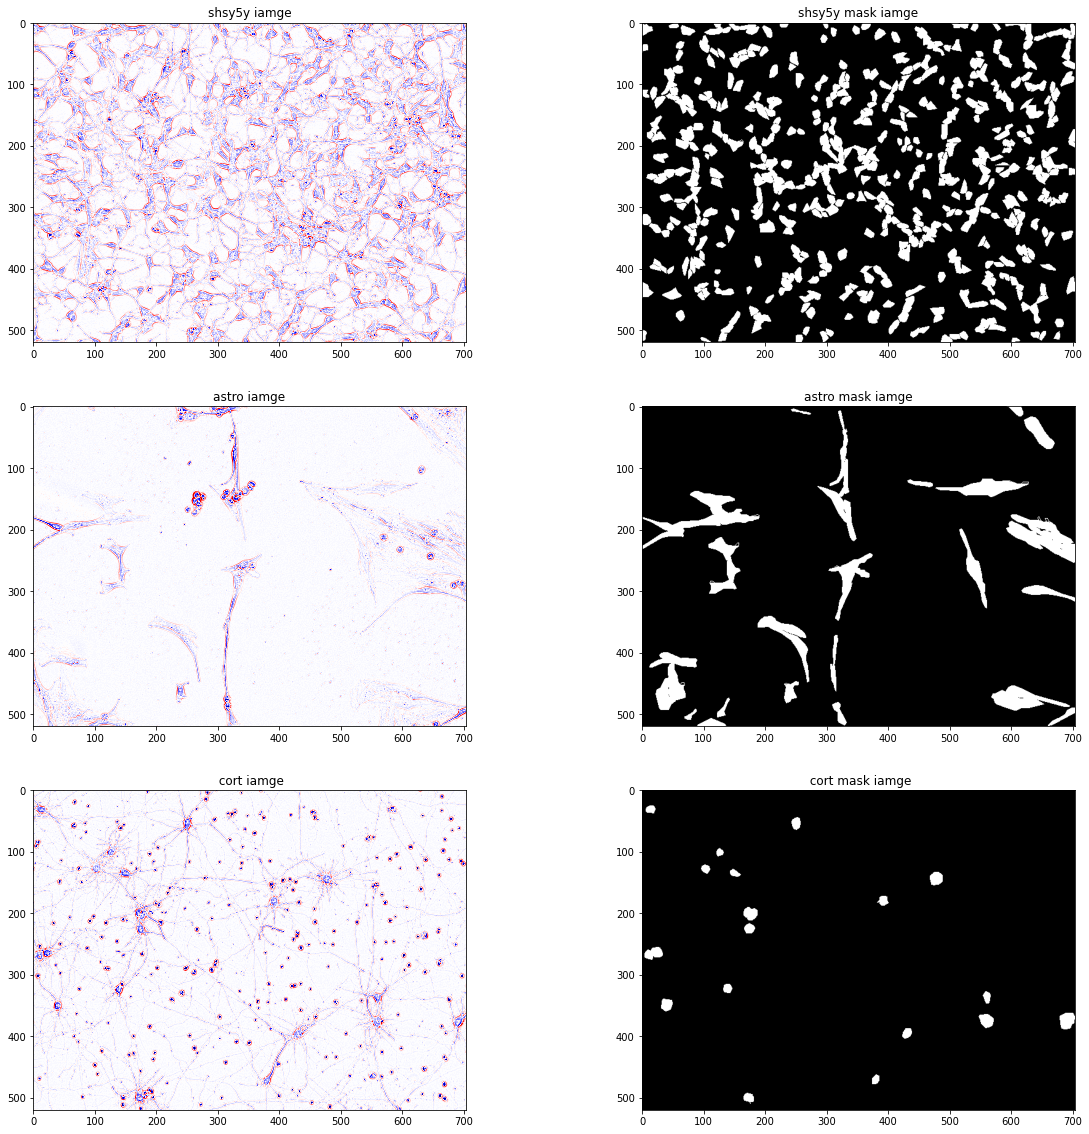

In [ ]:
data = load_data(ids)
plt.figure(figsize = (20,20))
plt.subplot(3,2, 1)
plt.imshow(data[0][0],cmap = 'seismic')
plt.title("shsy5y iamge")


plt.subplot(3,2,2)
plt.imshow(data[0][1].reshape(520, 704),cmap='gray')
plt.title("shsy5y mask iamge")

plt.subplot(3,2,3)
plt.imshow(data[1][0],cmap = 'seismic')
plt.title("astro iamge")


plt.subplot(3, 2, 4)
plt.imshow(data[1][1].reshape(520, 704),cmap='gray')
plt.title("astro mask iamge")

plt.subplot(3, 2, 5)
plt.imshow(data[2][0],cmap = 'seismic')
plt.title(" cort iamge")


plt.subplot(3, 2, 6)
plt.imshow(data[2][1].reshape(520, 704),cmap='gray')
plt.title(" cort mask iamge")


In [ ]:
image_ids = np.array(df_train['id'].unique())
len(image_ids)

606

In [ ]:
image_path = os.path.join(config.TRAIN_PATH, '0030fd0e6378' + ".png")
image = cv2.imread(image_path)
print(image.shape)
image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
clahe = cv2.createCLAHE(clipLimit = 5)
image = clahe.apply(image) + 30

(520, 704, 3)


In [ ]:
backtorgb = cv2.cvtColor(image,cv2.COLOR_GRAY2RGB)

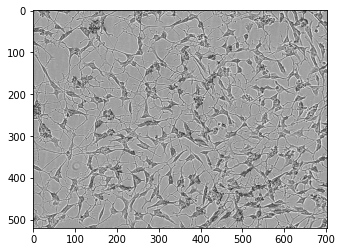

In [ ]:
plt.imshow(backtorgb)

In [ ]:
from PIL import Image, ImageEnhance

In [ ]:
from matplotlib import transforms
class CellDataset(Dataset):
  def __init__(self, df, transforms, train:bool):
    self.df = df
    self.transforms = transforms
    self.gb = self.df.groupby('id')

    image_ids = np.array(self.df['id'].unique())
    np.random.seed(42)
    random_idx = np.random.permutation(len(image_ids))
    split_train_thread = int(len(image_ids)*0.8)


    if train:
      self.image_ids = image_ids[random_idx[:split_train_thread]]
    else:
      self.image_ids = image_ids[random_idx[split_train_thread:]]
    
  
  def __getitem__(self, idx):
    image_id = self.image_ids[idx]
    df = self.df.groupby('id').get_group(image_id)

    # Read image
    image_path = os.path.join(config.TRAIN_PATH, image_id + ".png")
    image = cv2.imread(image_path)
    # brightness_enhancer = ImageEnhance.Brightness(image)
    # brighter_image = brightness_enhancer.enhance(factor=1.5)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    clahe = cv2.createCLAHE(clipLimit = 3,tileGridSize=(8,8))
    image = clahe.apply(image)
    image = cv2.cvtColor(image,cv2.COLOR_GRAY2RGB)

    # Create the mask
    mask = build_masks(df_train, image_id, input_shape=(520, 704))
    mask = (mask >= 1).astype('float32')

    if transforms is not None:
      augmented = self.transforms(image=image, mask= mask)
      image = augmented['image']
      mask = augmented['mask']
      # print(np.moveaxis(image,0,2).shape)
    return np.moveaxis(np.array(image),2,0), mask.reshape((1, config.IMAGE_RESIZE[0], config.IMAGE_RESIZE[1]))


  def __len__(self):
    return len(self.image_ids)
    

In [ ]:
from albumentations.augmentations.crops.functional import center_crop
transforms = Compose([transform.CenterCrop(512,512),
                      Resize(config.IMAGE_RESIZE[0], config.IMAGE_RESIZE[1]), 
                      Normalize(mean=config.RESNET_MEAN, std= config.RESNET_STD, p=1),])

In [ ]:
ds_train = CellDataset(df_train, transforms=transforms, train = True)
dl_train = DataLoader(ds_train, batch_size = 16,
                     num_workers = 2, pin_memory = True,
                     shuffle = False)

In [ ]:
ds_valid = CellDataset(df_train, transforms= transforms, train =  False)
dl_valid = DataLoader(ds_valid, batch_size = 4, 
                    num_workers = 2, pin_memory = True,
                    shuffle = False)

image shape: torch.Size([16, 3, 256, 256]),
mask shape:torch.Size([16, 1, 256, 256]),
batch len: 2


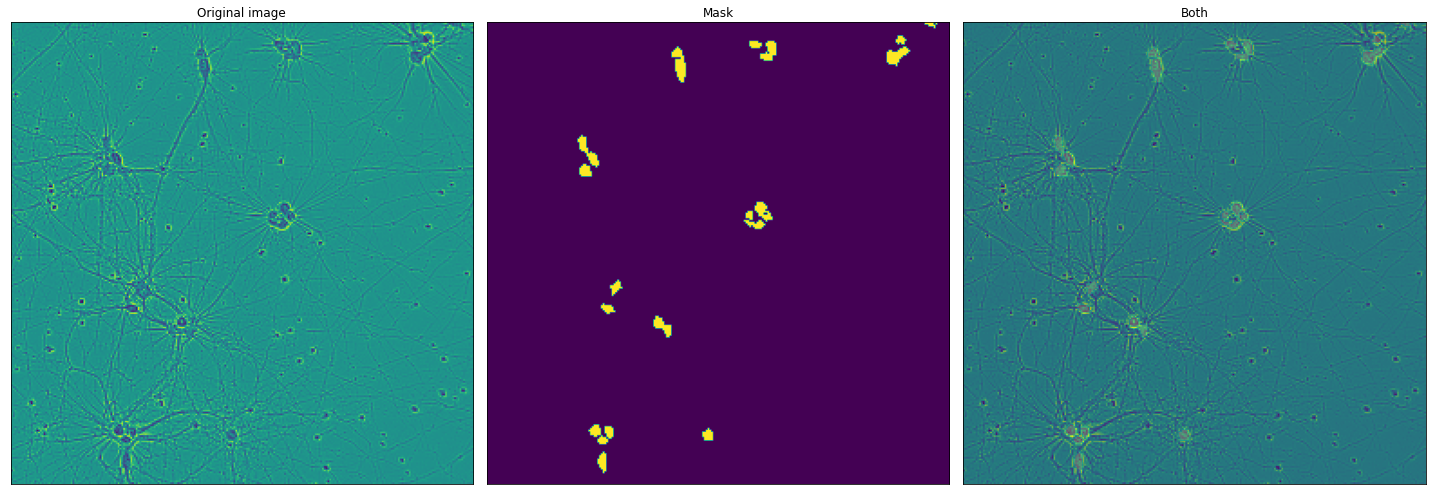

In [ ]:
# plot simages and mask from dataloader
batch = next(iter(dl_train))
images, masks = batch
print(f"image shape: {images.shape},\nmask shape:{masks.shape},\nbatch len: {len(batch)}")

plt.figure(figsize=(20, 20))
        
plt.subplot(1, 3, 1)
plt.xticks([])
plt.yticks([])
plt.imshow(images[1][1])
plt.title('Original image')

plt.subplot( 1, 3, 2)
plt.xticks([])
plt.yticks([])
plt.imshow(masks[1][0])
plt.title('Mask')

plt.subplot( 1, 3, 3)
plt.xticks([])
plt.yticks([])
plt.imshow(images[1][1])
plt.imshow(masks[1][0],alpha=0.2)
plt.title('Both')
plt.tight_layout()
plt.show()

image shape: torch.Size([4, 3, 256, 256]),
mask shape:torch.Size([4, 1, 256, 256]),
batch len: 2


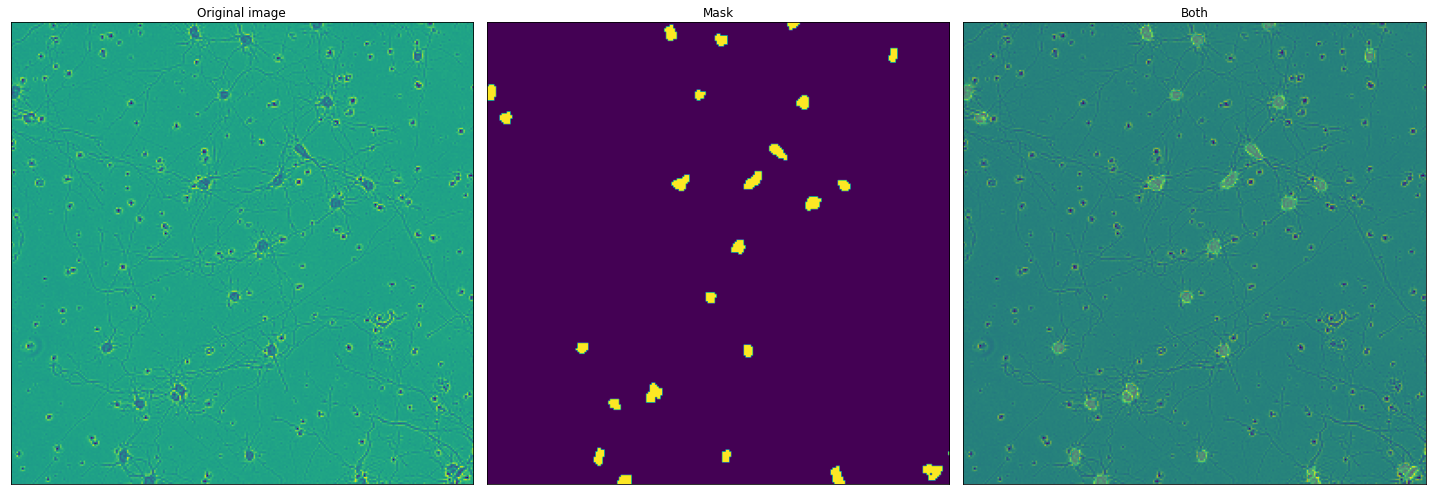

In [ ]:
# plot simages and mask from dataloader
batch = next(iter(dl_valid))
images, masks = batch
print(f"image shape: {images.shape},\nmask shape:{masks.shape},\nbatch len: {len(batch)}")

plt.figure(figsize=(20, 20))
        
plt.subplot(1, 3, 1)
plt.xticks([])
plt.yticks([])
plt.imshow(images[1][1])
plt.title('Original image')

plt.subplot( 1, 3, 2)
plt.xticks([])
plt.yticks([])
plt.imshow(masks[1][0])
plt.title('Mask')

plt.subplot( 1, 3, 3)
plt.xticks([])
plt.yticks([])
plt.imshow(images[1][1])
plt.imshow(masks[1][0],alpha=0.2)
plt.title('Both')
plt.tight_layout()
plt.show()

In [ ]:
class DiceLoss(torch.nn.Module):
    """
    class to compute the Dice Loss
    """
    def __init__(self):
        super().__init__()

    def forward(self, pred, mask):
                
        # Flatten label and prediction tensors
        pred = pred.view(-1)
        mask = mask.view(-1)
        counter = (pred * mask).sum()  # Numerator       
        denum = pred.sum() + mask.sum() + 1e-8  # Denominator. Add a small number to prevent NANS
        dice =  (2*counter)/denum
        return 1 - dice

In [ ]:
def train_loop(model, optimizer, criterion, train_loader, device=config.DEVICE):
    running_loss = 0
    model.train()
    pbar = tqdm(train_loader, desc='Iterating over train data')
    iou =[]
    dloss =[]
    accuracy =[]
    for imgs, masks in pbar:
        # pass to device
        imgs = imgs.to(config.DEVICE).float()
        masks = masks.to(config.DEVICE)
        # forward
        out = model(imgs)
        loss = criterion(out, masks)
        running_loss += loss.item()*imgs.shape[0]  # += loss * current batch size
        predicted = (out > 0.5).float()
        dl = DiceLoss()
        dice_loss = dl(predicted,masks)
        dloss.append(dice_loss)
        predicted = predicted.view(-1).cpu().numpy()
        labels = masks.view(-1).cpu().numpy()
        iou.append(jaccard_score(labels, predicted))
        acc= accuracy_score(labels, predicted)
        accuracy.append(acc)
        # optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    running_loss /= len(train_loader.sampler)
    iou = sum(iou)/ len(iou)
    dl = sum(dloss)/len(dloss)
    ac = sum(accuracy)/len(accuracy)
    return ac, running_loss, iou,dl

In [ ]:
def eval_loop(model, criterion, eval_loader, device=config.DEVICE):
    running_loss = 0
    model.eval()
    with torch.no_grad():
        accuracy, f1_scores, iou, dloss = [], [], [], []
        pbar = tqdm(eval_loader, desc='Iterating over evaluation data')
        for imgs, masks in pbar:
            # pass to device
            imgs = imgs.to(config.DEVICE).float()
            masks = masks.to(config.DEVICE).float()
            # forward
            out = model(imgs)
            loss = criterion(out, masks)
            running_loss += loss.item()*imgs.shape[0]
            # calculate predictions using output
            predicted = (out > 0.5).float()
            dl = DiceLoss()
            dice_loss = dl(predicted,masks)
            dloss.append(dice_loss)
            predicted = predicted.view(-1).cpu().numpy()
            labels = masks.view(-1).cpu().numpy()

            acc= accuracy_score(labels, predicted)
            accuracy.append(acc)

            f1_sc = f1_score(labels, predicted)
            f1_scores.append(f1_sc)

            io = jaccard_score(labels, predicted)
            iou.append(jaccard_score(labels, predicted))
            
    acc = sum(accuracy)/len(accuracy)
    f1 = sum(f1_scores)/len(f1_scores)
    iou = sum(iou)/ len(iou)
    running_loss /= len(eval_loader.sampler)
    dl = sum(dloss)/len(dloss)
    
    return {
        'accuracy':acc,
        'f1_macro':f1, 
        'loss':running_loss,
        'iou': iou,
        'dice_loss': dl}

In [ ]:
def train(model, optimizer, criterion, train_loader, valid_loader,
          device=config.DEVICE,
          num_epochs=50, 
          valid_loss_min=np.inf,
          logdir='logdir'):
    
    tb_writer = SummaryWriter(log_dir=logdir)
    for e in range(num_epochs):
        wandb.init(
        # Set entity to specify your username or team name
        # ex: entity="carey",
        # Set the project where this run will be logged
        project="Sartorius", 
        # Track hyperparameters and run metadata
        config={
        "learning_rate": 0.001,
        "architecture": "Unet++",
        "dataset": "CellDataset",})
        # train for epoch
        acc, train_loss, train_iou, train_dice_loss = train_loop(
            model, optimizer, criterion, train_loader, device=config.DEVICE)
        # evaluate on validation set
        metrics = eval_loop(
            model, criterion, valid_loader, device=config.DEVICE
        )
        wandb.log({"Step": e,"Accuracy":acc, "Train iou":train_iou,"BCEWithLogitsLoss": train_loss," train dice loss": train_dice_loss })

        # show progress
        print_string = f'Epoch: {e+1} '
        print_string+= f'Train Dice Loss: {train_dice_loss:.5f} '
        print_string+= f'Train Loss: {train_loss:.5f} '
        print_string+= f'Train Iou: {train_iou:.5f} '
        print_string+= f'Valid Dice Loss: {metrics["dice_loss"]:.5f} '
        print_string+= f'Valid Loss: {metrics["loss"]:.5f} '
        print_string+= f'ACC: {metrics["accuracy"]:.5f} '
        print_string+= f'F1: {metrics["f1_macro"]:.3f} '
        print_string+= f'Valid IoU: {metrics["iou"]:.3f} '
        print(print_string)

        # Tensorboards Logging
        tb_writer.add_scalar('UNet/Train Dice Loss',train_dice_loss, e)
        tb_writer.add_scalar('UNet/Train Loss', train_loss, e)
        tb_writer.add_scalar('UNet/Train Iou', train_iou, e)
        tb_writer.add_scalar('UNet/Valid Dice Loss',metrics["dice_loss"], e)
        tb_writer.add_scalar('UNet/Valid Loss', metrics["loss"], e)
        tb_writer.add_scalar('UNet/Accuracy', metrics["accuracy"], e)
        tb_writer.add_scalar('UNet/F1 Macro', metrics["f1_macro"], e)
        tb_writer.add_scalar('Unet/IoU', metrics["iou"], e)

        # save the model 
        if metrics["loss"] <= valid_loss_min:
            torch.save(model.state_dict(), 'UNet.pt')
            valid_loss_min = metrics["loss"]
           

In [ ]:
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
model = seg.Unet().to(config.DEVICE)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion=nn.BCEWithLogitsLoss(reduction='mean')
train(model, optimizer, criterion, dl_train, dl_valid)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

wandb: Currently logged in as: haidang22 (use `wandb login --relogin` to force relogin)


Iterating over evaluation data: 100%|██████████| 31/31 [00:44<00:00,  1.45s/it]


Epoch: 1 Train Dice Loss: 0.61378 Train Loss: 0.29056 Train Iou: 0.24873 Valid Dice Loss: 0.83966 Valid Loss: 0.17317 ACC: 0.92797 F1: 0.160 Valid IoU: 0.090 


Iterating over evaluation data: 100%|██████████| 31/31 [00:24<00:00,  1.29it/s]

Epoch: 2 Train Dice Loss: 0.37877 Train Loss: 0.16718 Train Iou: 0.45295 Valid Dice Loss: 0.40358 Valid Loss: 0.20534 ACC: 0.95003 F1: 0.596 Valid IoU: 0.433 


Iterating over evaluation data: 100%|██████████| 31/31 [00:24<00:00,  1.29it/s]


Epoch: 3 Train Dice Loss: 0.32506 Train Loss: 0.14737 Train Iou: 0.51093 Valid Dice Loss: 0.38038 Valid Loss: 0.13558 ACC: 0.94488 F1: 0.620 Valid IoU: 0.457 


Iterating over evaluation data: 100%|██████████| 31/31 [00:23<00:00,  1.29it/s]


Epoch: 4 Train Dice Loss: 0.29894 Train Loss: 0.13594 Train Iou: 0.54078 Valid Dice Loss: 0.31052 Valid Loss: 0.10252 ACC: 0.95713 F1: 0.689 Valid IoU: 0.533 


Iterating over evaluation data: 100%|██████████| 31/31 [00:24<00:00,  1.29it/s]

Epoch: 5 Train Dice Loss: 0.28479 Train Loss: 0.13026 Train Iou: 0.55807 Valid Dice Loss: 0.33029 Valid Loss: 0.10357 ACC: 0.95713 F1: 0.670 Valid IoU: 0.511 


Iterating over evaluation data: 100%|██████████| 31/31 [00:23<00:00,  1.30it/s]

Epoch: 6 Train Dice Loss: 0.28224 Train Loss: 0.12883 Train Iou: 0.56108 Valid Dice Loss: 0.37754 Valid Loss: 0.10604 ACC: 0.95367 F1: 0.622 Valid IoU: 0.459 


Iterating over evaluation data: 100%|██████████| 31/31 [00:24<00:00,  1.26it/s]

Epoch: 7 Train Dice Loss: 0.27644 Train Loss: 0.12508 Train Iou: 0.56799 Valid Dice Loss: 0.28623 Valid Loss: 0.11547 ACC: 0.95358 F1: 0.714 Valid IoU: 0.563 


Iterating over evaluation data: 100%|██████████| 31/31 [00:24<00:00,  1.27it/s]


Epoch: 8 Train Dice Loss: 0.25699 Train Loss: 0.12054 Train Iou: 0.59199 Valid Dice Loss: 0.29497 Valid Loss: 0.09777 ACC: 0.95865 F1: 0.705 Valid IoU: 0.551 


Iterating over evaluation data: 100%|██████████| 31/31 [00:24<00:00,  1.29it/s]


Epoch: 9 Train Dice Loss: 0.25120 Train Loss: 0.11827 Train Iou: 0.59952 Valid Dice Loss: 0.28128 Valid Loss: 0.09691 ACC: 0.95880 F1: 0.719 Valid IoU: 0.568 


Iterating over evaluation data: 100%|██████████| 31/31 [00:23<00:00,  1.31it/s]

Epoch: 10 Train Dice Loss: 0.24797 Train Loss: 0.11564 Train Iou: 0.60354 Valid Dice Loss: 0.33548 Valid Loss: 0.09739 ACC: 0.95712 F1: 0.665 Valid IoU: 0.506 


Iterating over evaluation data: 100%|██████████| 31/31 [00:23<00:00,  1.32it/s]


Epoch: 11 Train Dice Loss: 0.23495 Train Loss: 0.11176 Train Iou: 0.62034 Valid Dice Loss: 0.29847 Valid Loss: 0.09596 ACC: 0.95914 F1: 0.702 Valid IoU: 0.548 


Iterating over evaluation data: 100%|██████████| 31/31 [00:23<00:00,  1.32it/s]

Epoch: 12 Train Dice Loss: 0.22740 Train Loss: 0.10840 Train Iou: 0.63003 Valid Dice Loss: 0.28987 Valid Loss: 0.09673 ACC: 0.95931 F1: 0.710 Valid IoU: 0.558 


Iterating over evaluation data: 100%|██████████| 31/31 [00:23<00:00,  1.34it/s]

Epoch: 13 Train Dice Loss: 0.21964 Train Loss: 0.10524 Train Iou: 0.64051 Valid Dice Loss: 0.30463 Valid Loss: 0.10414 ACC: 0.95894 F1: 0.695 Valid IoU: 0.539 


Iterating over evaluation data: 100%|██████████| 31/31 [00:23<00:00,  1.32it/s]

Epoch: 14 Train Dice Loss: 0.20940 Train Loss: 0.10067 Train Iou: 0.65428 Valid Dice Loss: 0.29964 Valid Loss: 0.09757 ACC: 0.95848 F1: 0.700 Valid IoU: 0.546 


Iterating over evaluation data: 100%|██████████| 31/31 [00:24<00:00,  1.26it/s]

Epoch: 15 Train Dice Loss: 0.19726 Train Loss: 0.09547 Train Iou: 0.67103 Valid Dice Loss: 0.26396 Valid Loss: 0.10035 ACC: 0.95970 F1: 0.736 Valid IoU: 0.589 


Iterating over evaluation data: 100%|██████████| 31/31 [00:23<00:00,  1.32it/s]

Epoch: 16 Train Dice Loss: 0.18971 Train Loss: 0.09224 Train Iou: 0.68162 Valid Dice Loss: 0.28159 Valid Loss: 0.10409 ACC: 0.95843 F1: 0.718 Valid IoU: 0.568 


Iterating over evaluation data: 100%|██████████| 31/31 [00:23<00:00,  1.33it/s]

Epoch: 17 Train Dice Loss: 0.18191 Train Loss: 0.08898 Train Iou: 0.69264 Valid Dice Loss: 0.29676 Valid Loss: 0.10571 ACC: 0.95756 F1: 0.703 Valid IoU: 0.547 


Iterating over evaluation data: 100%|██████████| 31/31 [00:24<00:00,  1.29it/s]

Epoch: 18 Train Dice Loss: 0.17857 Train Loss: 0.08771 Train Iou: 0.69748 Valid Dice Loss: 0.29366 Valid Loss: 0.10611 ACC: 0.95817 F1: 0.706 Valid IoU: 0.551 


Iterating over evaluation data: 100%|██████████| 31/31 [00:23<00:00,  1.32it/s]

Epoch: 19 Train Dice Loss: 0.17383 Train Loss: 0.08516 Train Iou: 0.70433 Valid Dice Loss: 0.29917 Valid Loss: 0.11460 ACC: 0.95509 F1: 0.701 Valid IoU: 0.546 


Iterating over evaluation data: 100%|██████████| 31/31 [00:23<00:00,  1.31it/s]

Epoch: 20 Train Dice Loss: 0.17136 Train Loss: 0.08399 Train Iou: 0.70787 Valid Dice Loss: 0.30002 Valid Loss: 0.10705 ACC: 0.95684 F1: 0.700 Valid IoU: 0.544 


Iterating over evaluation data: 100%|██████████| 31/31 [00:23<00:00,  1.30it/s]

Epoch: 21 Train Dice Loss: 0.16800 Train Loss: 0.08232 Train Iou: 0.71280 Valid Dice Loss: 0.26809 Valid Loss: 0.12211 ACC: 0.95707 F1: 0.732 Valid IoU: 0.585 


Iterating over evaluation data: 100%|██████████| 31/31 [00:23<00:00,  1.31it/s]

Epoch: 22 Train Dice Loss: 0.16037 Train Loss: 0.08004 Train Iou: 0.72413 Valid Dice Loss: 0.33599 Valid Loss: 0.11754 ACC: 0.95541 F1: 0.664 Valid IoU: 0.502 


Iterating over evaluation data: 100%|██████████| 31/31 [00:24<00:00,  1.29it/s]

Epoch: 23 Train Dice Loss: 0.15746 Train Loss: 0.07801 Train Iou: 0.72836 Valid Dice Loss: 0.35862 Valid Loss: 0.12123 ACC: 0.95333 F1: 0.641 Valid IoU: 0.478 


Iterating over evaluation data: 100%|██████████| 31/31 [00:23<00:00,  1.32it/s]

Epoch: 24 Train Dice Loss: 0.15031 Train Loss: 0.07481 Train Iou: 0.73901 Valid Dice Loss: 0.36990 Valid Loss: 0.13114 ACC: 0.95104 F1: 0.630 Valid IoU: 0.465 


Iterating over evaluation data: 100%|██████████| 31/31 [00:24<00:00,  1.27it/s]

Epoch: 25 Train Dice Loss: 0.14669 Train Loss: 0.07316 Train Iou: 0.74457 Valid Dice Loss: 0.30913 Valid Loss: 0.11334 ACC: 0.95722 F1: 0.691 Valid IoU: 0.533 


Iterating over evaluation data: 100%|██████████| 31/31 [00:23<00:00,  1.30it/s]

Epoch: 26 Train Dice Loss: 0.14179 Train Loss: 0.07112 Train Iou: 0.75212 Valid Dice Loss: 0.28832 Valid Loss: 0.11967 ACC: 0.95802 F1: 0.712 Valid IoU: 0.559 


Iterating over evaluation data: 100%|██████████| 31/31 [00:24<00:00,  1.26it/s]

Epoch: 27 Train Dice Loss: 0.13908 Train Loss: 0.06944 Train Iou: 0.75618 Valid Dice Loss: 0.27620 Valid Loss: 0.11524 ACC: 0.95930 F1: 0.724 Valid IoU: 0.574 


Iterating over evaluation data: 100%|██████████| 31/31 [00:24<00:00,  1.29it/s]

Epoch: 28 Train Dice Loss: 0.13491 Train Loss: 0.06750 Train Iou: 0.76263 Valid Dice Loss: 0.27660 Valid Loss: 0.11686 ACC: 0.95843 F1: 0.723 Valid IoU: 0.573 


Iterating over evaluation data: 100%|██████████| 31/31 [00:25<00:00,  1.24it/s]

Epoch: 29 Train Dice Loss: 0.12893 Train Loss: 0.06515 Train Iou: 0.77186 Valid Dice Loss: 0.28115 Valid Loss: 0.11480 ACC: 0.95964 F1: 0.719 Valid IoU: 0.568 


Iterating over evaluation data: 100%|██████████| 31/31 [00:23<00:00,  1.30it/s]

Epoch: 30 Train Dice Loss: 0.12761 Train Loss: 0.06409 Train Iou: 0.77396 Valid Dice Loss: 0.26673 Valid Loss: 0.11784 ACC: 0.95984 F1: 0.733 Valid IoU: 0.585 


Iterating over evaluation data: 100%|██████████| 31/31 [00:24<00:00,  1.26it/s]

Epoch: 31 Train Dice Loss: 0.12830 Train Loss: 0.06410 Train Iou: 0.77293 Valid Dice Loss: 0.30924 Valid Loss: 0.12537 ACC: 0.95726 F1: 0.691 Valid IoU: 0.532 


Iterating over evaluation data: 100%|██████████| 31/31 [00:24<00:00,  1.26it/s]

Epoch: 32 Train Dice Loss: 0.12170 Train Loss: 0.06115 Train Iou: 0.78330 Valid Dice Loss: 0.31189 Valid Loss: 0.12485 ACC: 0.95701 F1: 0.688 Valid IoU: 0.529 


Iterating over evaluation data: 100%|██████████| 31/31 [00:24<00:00,  1.27it/s]

Epoch: 33 Train Dice Loss: 0.11602 Train Loss: 0.05876 Train Iou: 0.79231 Valid Dice Loss: 0.29625 Valid Loss: 0.12426 ACC: 0.95864 F1: 0.704 Valid IoU: 0.549 


Iterating over evaluation data: 100%|██████████| 31/31 [00:24<00:00,  1.27it/s]

Epoch: 34 Train Dice Loss: 0.11194 Train Loss: 0.05672 Train Iou: 0.79892 Valid Dice Loss: 0.29852 Valid Loss: 0.11840 ACC: 0.95918 F1: 0.701 Valid IoU: 0.544 


Iterating over evaluation data: 100%|██████████| 31/31 [00:24<00:00,  1.28it/s]

Epoch: 35 Train Dice Loss: 0.10912 Train Loss: 0.05485 Train Iou: 0.80351 Valid Dice Loss: 0.27005 Valid Loss: 0.11863 ACC: 0.95983 F1: 0.730 Valid IoU: 0.580 


Iterating over evaluation data: 100%|██████████| 31/31 [00:24<00:00,  1.29it/s]

Epoch: 36 Train Dice Loss: 0.10909 Train Loss: 0.05538 Train Iou: 0.80360 Valid Dice Loss: 0.27106 Valid Loss: 0.13499 ACC: 0.95704 F1: 0.729 Valid IoU: 0.580 


Iterating over evaluation data: 100%|██████████| 31/31 [00:24<00:00,  1.28it/s]

Epoch: 37 Train Dice Loss: 0.11040 Train Loss: 0.05578 Train Iou: 0.80162 Valid Dice Loss: 0.29598 Valid Loss: 0.12787 ACC: 0.95768 F1: 0.704 Valid IoU: 0.550 


Iterating over evaluation data: 100%|██████████| 31/31 [00:23<00:00,  1.29it/s]

Epoch: 38 Train Dice Loss: 0.10740 Train Loss: 0.05443 Train Iou: 0.80630 Valid Dice Loss: 0.31252 Valid Loss: 0.13871 ACC: 0.95590 F1: 0.687 Valid IoU: 0.528 


Iterating over evaluation data: 100%|██████████| 31/31 [00:24<00:00,  1.25it/s]

Epoch: 39 Train Dice Loss: 0.10844 Train Loss: 0.05478 Train Iou: 0.80471 Valid Dice Loss: 0.27366 Valid Loss: 0.13044 ACC: 0.95817 F1: 0.726 Valid IoU: 0.576 


Iterating over evaluation data: 100%|██████████| 31/31 [00:24<00:00,  1.26it/s]

Epoch: 40 Train Dice Loss: 0.10538 Train Loss: 0.05315 Train Iou: 0.80962 Valid Dice Loss: 0.28845 Valid Loss: 0.13219 ACC: 0.95760 F1: 0.712 Valid IoU: 0.557 


Iterating over evaluation data: 100%|██████████| 31/31 [00:23<00:00,  1.31it/s]

Epoch: 41 Train Dice Loss: 0.10539 Train Loss: 0.05356 Train Iou: 0.80963 Valid Dice Loss: 0.29191 Valid Loss: 0.13830 ACC: 0.95675 F1: 0.708 Valid IoU: 0.554 


Iterating over evaluation data: 100%|██████████| 31/31 [00:23<00:00,  1.32it/s]

Epoch: 42 Train Dice Loss: 0.10558 Train Loss: 0.05334 Train Iou: 0.80942 Valid Dice Loss: 0.28704 Valid Loss: 0.14234 ACC: 0.95776 F1: 0.713 Valid IoU: 0.560 


Iterating over evaluation data: 100%|██████████| 31/31 [00:23<00:00,  1.30it/s]

Epoch: 43 Train Dice Loss: 0.10071 Train Loss: 0.05093 Train Iou: 0.81728 Valid Dice Loss: 0.32518 Valid Loss: 0.14300 ACC: 0.95275 F1: 0.675 Valid IoU: 0.514 


Iterating over evaluation data: 100%|██████████| 31/31 [00:23<00:00,  1.31it/s]

Epoch: 44 Train Dice Loss: 0.10568 Train Loss: 0.05342 Train Iou: 0.80914 Valid Dice Loss: 0.29100 Valid Loss: 0.13233 ACC: 0.95817 F1: 0.709 Valid IoU: 0.553 


Iterating over evaluation data: 100%|██████████| 31/31 [00:24<00:00,  1.28it/s]

Epoch: 45 Train Dice Loss: 0.10337 Train Loss: 0.05223 Train Iou: 0.81288 Valid Dice Loss: 0.28512 Valid Loss: 0.12930 ACC: 0.95902 F1: 0.715 Valid IoU: 0.562 


Iterating over evaluation data: 100%|██████████| 31/31 [00:24<00:00,  1.27it/s]

Epoch: 46 Train Dice Loss: 0.10623 Train Loss: 0.05380 Train Iou: 0.80833 Valid Dice Loss: 0.27977 Valid Loss: 0.12276 ACC: 0.95923 F1: 0.720 Valid IoU: 0.567 


Iterating over evaluation data: 100%|██████████| 31/31 [00:23<00:00,  1.31it/s]

Epoch: 47 Train Dice Loss: 0.11173 Train Loss: 0.05674 Train Iou: 0.79949 Valid Dice Loss: 0.29705 Valid Loss: 0.12763 ACC: 0.95860 F1: 0.703 Valid IoU: 0.548 


Iterating over evaluation data: 100%|██████████| 31/31 [00:23<00:00,  1.31it/s]

Epoch: 48 Train Dice Loss: 0.11973 Train Loss: 0.06005 Train Iou: 0.78649 Valid Dice Loss: 0.28299 Valid Loss: 0.12299 ACC: 0.95825 F1: 0.717 Valid IoU: 0.565 


Iterating over evaluation data: 100%|██████████| 31/31 [00:23<00:00,  1.32it/s]


Epoch: 49 Train Dice Loss: 0.10875 Train Loss: 0.05481 Train Iou: 0.80406 Valid Dice Loss: 0.27448 Valid Loss: 0.12540 ACC: 0.95859 F1: 0.726 Valid IoU: 0.575 


Iterating over evaluation data: 100%|██████████| 31/31 [00:23<00:00,  1.30it/s]

Epoch: 50 Train Dice Loss: 0.10016 Train Loss: 0.05100 Train Iou: 0.81817 Valid Dice Loss: 0.31688 Valid Loss: 0.14213 ACC: 0.95597 F1: 0.683 Valid IoU: 0.523 


In [ ]:
model.load_state_dict(torch.load('UNet.pt'))
metrics = eval_loop(model, criterion, dl_valid)
print('accuracy:', metrics['accuracy'])
print('f1 macro:', metrics['f1_macro'])
print('valid loss:', metrics['loss'])
print('valid dice loss:', metrics['dice_loss'])
print('Iou: ', metrics['iou'])

Iterating over evaluation data: 100%|██████████| 31/31 [00:23<00:00,  1.30it/s]

accuracy: 0.9591426234091481
f1 macro: 0.7015315504313385
valid loss: 0.09596221643637438
valid dice loss: tensor(0.2985, device='cuda:0')
Iou:  0.5476229465741937


In [ ]:
model.load_state_dict(torch.load('UNet.pt'))

<All keys matched successfully>

In [ ]:
from albumentations.pytorch.transforms import ToTensorV2
import torch.nn.functional as F

In [ ]:
model

UnetPlusPlus(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=Tru

In [ ]:
#test loader
class TestDataset(Dataset):
    def __init__(self, test_dir, mean, std, size):
        self.test_dir = test_dir
        self.images = os.listdir(test_dir)
        self.transform = Compose(
            [
                Normalize(mean=mean, std=std, p=1),
                Resize(size, size),
                ToTensorV2()
            ]
        )
        
    def __len__(self):
        return len(self.images)

    
    def __getitem__(self,idx):
        img_name = self.images[idx]
        img_path = os.path.join(self.test_dir,img_name)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        image = self.transform(image=img)
        image = image["image"]
        return image,img_name

In [ ]:
size = 256
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)
TEST_DIR = '/content/gdrive/MyDrive/Kaggle_challenge/data/test'

test_data = TestDataset(TEST_DIR, mean, std, size)
test_loader = torch.utils.data.DataLoader(dataset=test_data, batch_size=2, num_workers=2, pin_memory=True)

  0%|          | 0/2 [00:00<?, ?it/s]

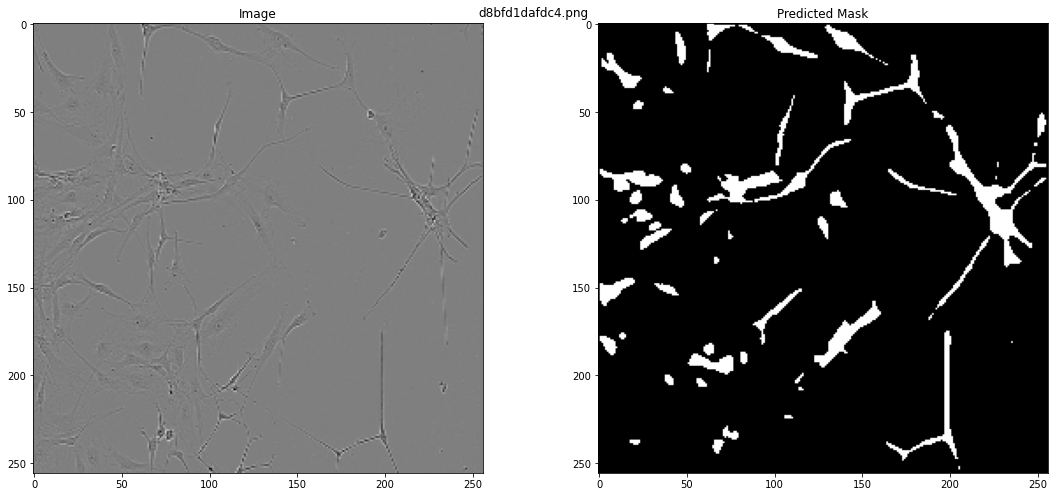

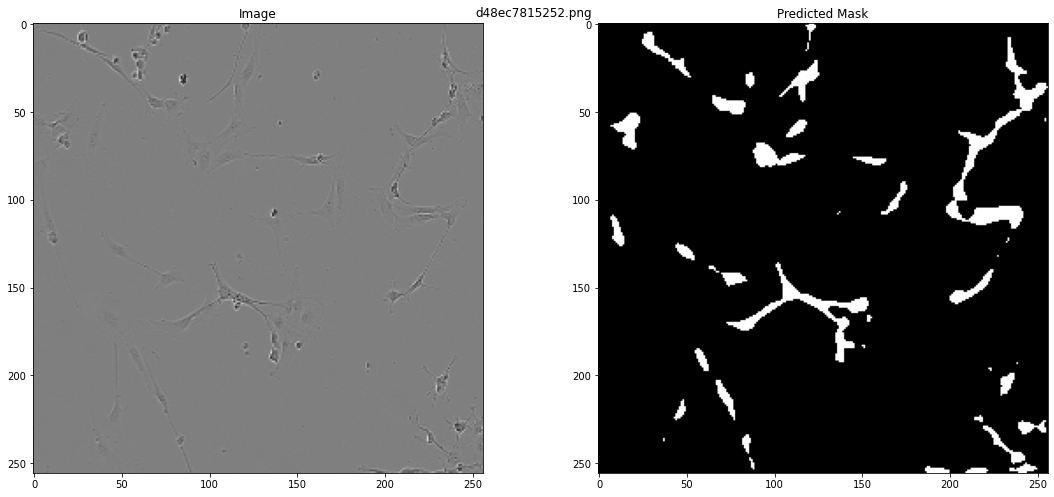

 50%|█████     | 1/2 [00:02<00:02,  2.77s/it]

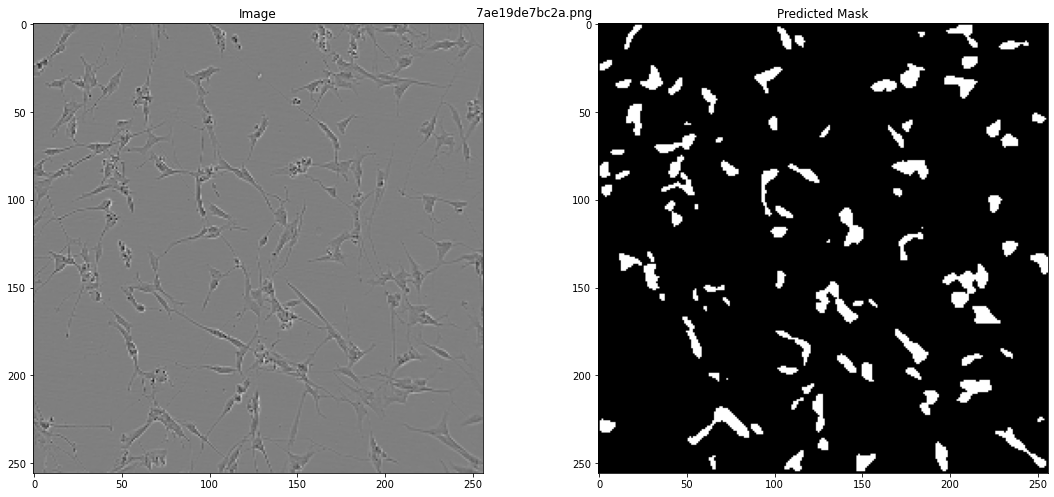

100%|██████████| 2/2 [00:03<00:00,  1.82s/it]


In [ ]:
def predict_mask(batch):
    y_pred = torch.sigmoid(model(batch.cuda()))
    return y_pred

def mask_convert(mask):
    mask = mask.clone().cpu().detach().numpy()
    mask = mask.transpose((1,2,0))
    mask = np.squeeze(mask)
    return mask


# converting tensor to image
def image_convert(image):
    image = image.clone().cpu().numpy()
    image = image.transpose((1,2,0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image  = std * image + mean
    image = image.clip(0,1)
    image = (image * 255).astype(np.uint8)
    return image


for img,img_names in tqdm(test_loader):
    masks = predict_mask(img)
    for i,mask in enumerate(masks):
        mask = mask_convert(mask)
        mask = np.where(mask > 0.65, 1, 0)
        image = img[i]
        image = image_convert(image)
        fig,axes = plt.subplots(1,2,figsize=(16,7))
        axes[0].imshow(image)
        axes[0].set_title('Image')
        axes[1].imshow(mask,cmap="gray")
        axes[1].set_title('Predicted Mask')
        plt.suptitle(img_names[i])
        plt.tight_layout()
        plt.show()

In [ ]:
def ins2rle(ins):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    ins    = np.array(ins)
    pixels = ins.flatten()
    pad    = np.array([0])
    pixels = np.concatenate([pad, pixels, pad])
    runs   = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    rles = ' '.join(str(x) for x in runs)
    return rles

def mask2rle(mask, cutoff=0.65, min_object_size=1.0):
    """ Return run length encoding of mask. 
        ref: https://www.kaggle.com/raoulma/nuclei-dsb-2018-tensorflow-u-net-score-0-352
    """
    # segment image and label different objects
    lab_mask = skimage.morphology.label(mask > cutoff)
    
     
    # Keep only objects that are large enough.
    (mask_labels, mask_sizes) = np.unique(lab_mask, return_counts=True)
    

    if (mask_sizes < min_object_size).any():
#         print(mask_sizes)
        mask_labels = mask_labels[mask_sizes < min_object_size]
        
        for n in mask_labels:
            lab_mask[lab_mask == n] = 0
        lab_mask = skimage.morphology.label(lab_mask > cutoff) 
        
    rles = []
    # Loop over each object excluding the background labeled by 0.
    for i in range(1, lab_mask.max() + 1):
        rle = ins2rle(lab_mask == i)
        rles.append(rle)
        
    return rles

In [ ]:
import skimage

In [ ]:
pred_rles , pred_paths = [],[]
for img,img_name in test_loader:
    masks = predict_mask(img)
    for i,mask in enumerate(masks):
        mask = mask_convert(mask)
        msk = cv2.resize(mask,(704,520),interpolation=cv2.INTER_NEAREST)
        rle_list = mask2rle(msk)
        img_id = img_name[i].split('.')[0]
        idx_list = [img_id for i in range(len(rle_list))] 
        pred_rles.extend(rle_list)
        pred_paths.extend(idx_list)

In [ ]:
df = pd.DataFrame({'id':pred_paths, 'predicted':pred_rles})
df.to_csv('./submission.csv', index=False)
df = pd.read_csv('./submission.csv')
df

id                                          predicted
0    d8bfd1dafdc4  172 11 876 11 1580 11 2284 44 2988 44 3692 36 ...
1    d8bfd1dafdc4  2333 14 3037 14 3747 14 4451 14 5160 11 5864 1...
2    d8bfd1dafdc4  2471 5 3175 5 3876 11 4580 11 5287 14 5991 14 ...
3    d8bfd1dafdc4  7866 6 8570 6 9274 9 9978 9 10682 9 11386 9 12...
4    d8bfd1dafdc4  10817 14 11521 14 12231 27 12935 27 13641 28 1...
..            ...                                                ...
182  7ae19de7bc2a  338271 5 338975 5 339676 11 340380 11 341084 1...
183  7ae19de7bc2a  341268 3 341972 3 342673 9 343377 9 344081 11 ...
184  7ae19de7bc2a  348094 5 348798 5 349499 8 350203 8 350904 11 ...
185  7ae19de7bc2a  351000 3 351020 8 351704 3 351724 8 352406 30 ...
186  7ae19de7bc2a  352180 6 352884 6 353583 8 354287 8 354991 8 3...

[187 rows x 2 columns]

In [ ]:
from google.colab import files
files.download('submission.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from google.colab import files
files.download('/content/UNet.pt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>